### moers_bins_v04.ipynb



The content of this Notebook is based on [this](https://automating-gis-processes.github.io/2017/course-info/course-info.html) course from the University of Helsinki.

And the [this](https://mlrose.readthedocs.io/en/stable/source/tutorial2.html) tutorial for solving the Travelling Salesman Problem with `mlrose`.

In [1]:
import mlrose
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from geopandas.tools import geocode
from itertools import chain
from shapely.geometry import LineString, Point

C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Import street network of Moers from OpenStreetMaps 
#### network_type='bike' or 'drive' or 'walk'

In [2]:
place_name = "Moers, Germany"
graph = ox.graph_from_place(place_name, network_type='drive')
#ox.save_load.save_graph_shapefile(graph, "Moers", folder="Data/")

In [3]:
#ox.save_load.save_as_osm(graph, "Moers", folder="Data/")

In [4]:
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [5]:
nodes.crs

'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

### Geocode the starting point (ENNI Betriebshof)

In [6]:
# Geocode addresses with Nominatim backend
start = geocode("Am Jostenhof 7-9, 47441 Moers, Germany", provider='nominatim')
start.crs

{'init': 'epsg:4326', 'no_defs': True}

### Import shapefile (created with QGIS) of bins in Moers

In [7]:
fp = "Data/bins_Moers.shp"
bins = gpd.read_file(fp)
bins.crs

{'init': 'epsg:4326'}

### Reproject the points to the same projection as the road network

In [8]:
proj_text = str.format(edges.crs)

# Reproject the geometries by replacing the values with projected ones
bins = bins.to_crs(proj_text)
#end_point = points_proj.iloc[np.argmin(distances)]
#data_bin_proj.crs = CRS("EPSG:32632")
start = start.to_crs(proj_text)
proj_text

C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\sarah\Anaconda3\envs\geo_py_37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

### Reformat start point

In [9]:
start_point = start.geometry
start_xy = (start_point.y.item(), start_point.x.item())
start_xy

(51.4525429, 6.607198265428346)

### Sample 10 "full" bins

In [10]:
sample_bin = bins.sample(n=10)
sample_bin.head()

,Name,Latitude,Longitude,lfd# Nr#,Stadtteil,Anzahl_beh,ort,Straße,Art,Abfuhrtag,Woche-g-ug,Telefon,Zeitbedarf,geometry
1008,Papierkorb 200000872,51.450073,6.664658,2147,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.66466 51.45007)
583,Papierkorb 200000661,51.478801,6.627248,1722,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.62725 51.47880)
407,Papierkorb 200000367,51.450862,6.631152,1546,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.63115 51.45086)
928,Papierkorb 200000695,51.456002,6.654602,2067,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.65460 51.45600)
396,Papierkorb 200000325,51.451781,6.630373,1535,None,1,Moers,None,Papierkorb,None,None,None,0.5,POINT (6.63037 51.45178)


In [11]:
sample_points = sample_bin.geometry

In [12]:
sample_points

1008    POINT (6.66466 51.45007)
583     POINT (6.62725 51.47880)
407     POINT (6.63115 51.45086)
928     POINT (6.65460 51.45600)
396     POINT (6.63037 51.45178)
902     POINT (6.65054 51.45036)
116     POINT (6.62542 51.39965)
1074    POINT (6.65172 51.46693)
1048    POINT (6.64358 51.46329)
600     POINT (6.63568 51.47934)
Name: geometry, dtype: geometry

In [13]:
sample_xy = []

### Add start point to bin samples

In [14]:
sample_xy.append(start_xy)

In [15]:
sample_xy

[(51.4525429, 6.607198265428346)]

### Reformat points of "full" bins

In [16]:
for index in range(0,sample_points.count()):
    sample_xy.append((sample_points.iloc[index].y, sample_points.iloc[index].x))

In [17]:
type(sample_xy)

list

#### Initialize fitness function object by using a list coordinates (sample_x_y)

In [18]:
fitness_coords = mlrose.TravellingSales(coords = sample_xy)

#### Define optimization problem object

In [19]:
problem_fit = mlrose.TSPOpt(length = len(sample_xy), fitness_fn = fitness_coords, maximize=False)

In [20]:
# Solve problem using the genetic algorithm
best_state, best_fitness, fitness_curve = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, max_attempts = 50, random_state = 2, curve = True)

print(best_state)
print(best_fitness)

[ 7  0  3  5 10  2  8  9  6  4  1]
0.2509828106218624


In [21]:
#print(fitness_curve)

### Calculate the network nodes that are closest to start and end point

In [22]:
route = []

In [23]:
#route = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')

In [24]:
#fig, ax = ox.plot_graph_route(graph, route, origin_point=orig_xy, destination_point=target_xy, show=False, close=False)

#sample_bin.plot(ax=ax, color='red', markersize=5)

#plt.tight_layout()

In [25]:
for index in range(0,sample_points.count()+1):
    
    if index == int(sample_points.count()):
        orig_xy = sample_xy[best_state[-1]]
        target_xy = sample_xy[best_state[0]]
        print("!!!")
        
    else:
    
        orig_xy = sample_xy[best_state[index]]
        target_xy = sample_xy[best_state[index+1]]
    
    orig_node = ox.get_nearest_node(graph, orig_xy, method='euclidean')
    target_node = ox.get_nearest_node(graph, target_xy, method='euclidean')
    
    #print(orig_node)
    #print(target_node)
    
    route_temp = nx.shortest_path(G=graph, source=orig_node, target=target_node, weight='length')
    print(route)
    route.append(route_temp)
    route_temp = []

[]
[[432942113, 432953630, 432957906, 432957901, 432953629, 432953624, 266742869, 266742878, 266741454, 266741460, 281162017, 1310706501, 291907869, 1283775270, 1229130159, 1291731859, 879495457, 637694167, 637694172, 57560268, 1137815076, 1964674384, 57582237, 35961854, 57582234, 1137581827, 87116860, 1137582055, 26111401, 1219295401, 1559488104, 204903898, 204903896, 204903907, 204903840, 204919361, 204903804, 204903923, 204903924, 1549405677, 1549405682, 26881444]]
[[432942113, 432953630, 432957906, 432957901, 432953629, 432953624, 266742869, 266742878, 266741454, 266741460, 281162017, 1310706501, 291907869, 1283775270, 1229130159, 1291731859, 879495457, 637694167, 637694172, 57560268, 1137815076, 1964674384, 57582237, 35961854, 57582234, 1137581827, 87116860, 1137582055, 26111401, 1219295401, 1559488104, 204903898, 204903896, 204903907, 204903840, 204919361, 204903804, 204903923, 204903924, 1549405677, 1549405682, 26881444], [26881444, 1549405682, 1784946264, 1549405688, 204915722,

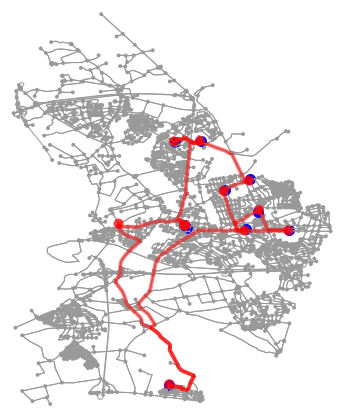

In [26]:
fig, ax = ox.plot_graph_routes(graph, route, save=True, show=False, close=False)

sample_bin.plot(ax=ax, color='blue', markersize=100)

plt.tight_layout()

### Combine the nodes of the route with information from the network

In [27]:
route_nodes = nodes.loc[list(chain(*route))]

In [28]:
print(route_nodes)

                   y         x      osmid highway  ref  \
432942113  51.399723  6.625472  432942113     NaN  NaN   
432953630  51.399282  6.625320  432953630     NaN  NaN   
432957906  51.399000  6.627397  432957906     NaN  NaN   
432957901  51.398856  6.628581  432957901     NaN  NaN   
432953629  51.398756  6.629698  432953629     NaN  NaN   
...              ...       ...        ...     ...  ...   
432953629  51.398756  6.629698  432953629     NaN  NaN   
432957901  51.398856  6.628581  432957901     NaN  NaN   
432957906  51.399000  6.627397  432957906     NaN  NaN   
432953630  51.399282  6.625320  432953630     NaN  NaN   
432942113  51.399723  6.625472  432942113     NaN  NaN   

                           geometry  
432942113  POINT (6.62547 51.39972)  
432953630  POINT (6.62532 51.39928)  
432957906  POINT (6.62740 51.39900)  
432957901  POINT (6.62858 51.39886)  
432953629  POINT (6.62970 51.39876)  
...                             ...  
432953629  POINT (6.62970 51.39876)  

### Convert route into a linestring

In [29]:
route_line = LineString(list(route_nodes.geometry.values))
print(route_line)

LINESTRING (6.6254717 51.3997225, 6.6253202 51.3992819, 6.6273969 51.399, 6.628581 51.3988563, 6.6296983 51.3987555, 6.6315484 51.3977998, 6.6323895 51.4002799, 6.6336085 51.4025028, 6.6282178 51.4060475, 6.6256636 51.4118454, 6.6191144 51.4183258, 6.6180897 51.4188294, 6.6164895 51.419466, 6.6163133 51.4203872, 6.6139259 51.4236037, 6.6128261 51.4246506, 6.6122095 51.4252746, 6.6119531 51.4255342, 6.6116486 51.4258221, 6.6112508 51.4267993, 6.607942 51.4330983, 6.6076236 51.4336075, 6.6088564 51.4347515, 6.6092064 51.4353258, 6.6093424 51.4356696, 6.6095369 51.4368028, 6.6095239 51.4374582, 6.6094889 51.4378725, 6.6124317 51.4433261, 6.6126091 51.4435013, 6.6161763 51.4465757, 6.6155345 51.4468482, 6.6149658 51.4470896, 6.6144424 51.4473119, 6.612252 51.4480763, 6.6116623 51.4483004, 6.6106733 51.4488805, 6.6098575 51.4496182, 6.6095986 51.4499483, 6.6090601 51.4511341, 6.6092623 51.4511478, 6.6088813 51.4522316, 6.6088813 51.4522316, 6.6092623 51.4511478, 6.6118892 51.451221, 6.61486

### Create a GeoDataFrame from the linestring

In [30]:
route_geom = gpd.GeoDataFrame(crs=edges.crs)

route_geom['geometry'] = None
route_geom['osmids'] = None

In [31]:
route_geom.loc[0, 'geometry'] = route_line

route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

### Plot the route s dashed line onto the nodes and edges of the network

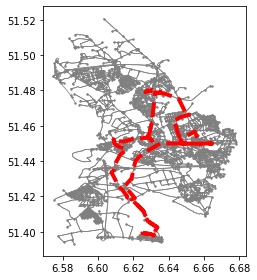

In [32]:
fig, ax = plt.subplots()
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')
route_geom.plot(ax=ax, linewidth=4, linestyle='--', color='red')
plt.tight_layout()

### Prepare the saving of shapefiles

In [33]:
place_name_out = place_name.replace(' ', '_').replace(',','')
#streets_out = r"Data/%s_streets.shp" % place_name_out
route_out = r"Data/Route_%s.shp" % place_name_out

In [34]:
#edges.to_file(streets_out)

In [35]:
route_geom.to_file(route_out)

In [36]:
route

[[432942113,
  432953630,
  432957906,
  432957901,
  432953629,
  432953624,
  266742869,
  266742878,
  266741454,
  266741460,
  281162017,
  1310706501,
  291907869,
  1283775270,
  1229130159,
  1291731859,
  879495457,
  637694167,
  637694172,
  57560268,
  1137815076,
  1964674384,
  57582237,
  35961854,
  57582234,
  1137581827,
  87116860,
  1137582055,
  26111401,
  1219295401,
  1559488104,
  204903898,
  204903896,
  204903907,
  204903840,
  204919361,
  204903804,
  204903923,
  204903924,
  1549405677,
  1549405682,
  26881444],
 [26881444,
  1549405682,
  1784946264,
  1549405688,
  204915722,
  26881453,
  26881456,
  1989819081,
  26111405,
  80163539,
  26931571,
  26111407,
  26597881,
  656649108,
  2168976908,
  2168976910,
  656649123,
  80179826,
  26140121,
  26140126],
 [26140126, 26140121],
 [26140121,
  80179826,
  26140120,
  656649125,
  80163533,
  2168976917,
  2168976925,
  25811665,
  25811664,
  25811662,
  60200049,
  26308055,
  1299517688,
  1299